# IFT 6758 - Devoir 3 

### Pt 1. Reddit Weekends

Évaluation pour ce notebook:

- Histogrammes pour les counts de base, les counts transformés, et les counts du théorème limite central
- Réponses courtes (dernière section)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from datetime import date
import scipy.stats as sp

In [4]:
import reddit_weekends

## 1. Charger les données

Lire les données JSON et filtrer/nettoyer le dataframe

In [5]:
raw_df = reddit_weekends.read_data("data/reddit-counts.json.gz")

In [6]:
raw_df.head()

,date,subreddit,comment_count
0,2012-02-20,newfoundland,7
1,2015-01-26,Manitoba,1
2,2013-09-07,Yukon,2
3,2014-02-15,saskatchewan,5
4,2014-07-06,canada,1652


In [7]:
df = reddit_weekends.process_data(raw_df)
wd, we = reddit_weekends.split_data(df)

### T-Test

In [8]:
p_ttest, p_wdNormal, p_weNormal, p_vartest = reddit_weekends.tests(wd, we, verbose=True)

p_value:	0.0
WD normality:	0.0
WE normality:	0.00152
Variance test:	0.04379


### Solution 1: transformer les données pourrait nous aider

Jetez un oeil à l'histogramme des données. Vous remarquerez qu'il est biaisé: c'est la raison pour laquelle il n'a pas été distribué normalement dans la dernière partie. Essayez de transformer les décomptes afin que les données n'échouent pas au test de normalité. Considérez les transformations suivantes :

     np.log, np.exp, np.sqrt, counts**2
    
Pour chaque transformation, tracez le nouvel histogramme (`reddit_weekends.draw_histogram()`) et exécutez la méthode `reddit_weekends.tests()` pour voir si vous pouvez maintenant utiliser le test T.
    
Remarque: aucune d'entre elles ne fera passer le test de normalité aux deux distributions. Le mieux que vous pouvez obtenir est une variable avec des problèmes de normalité, une bonne; pas de problèmes de variance égale.

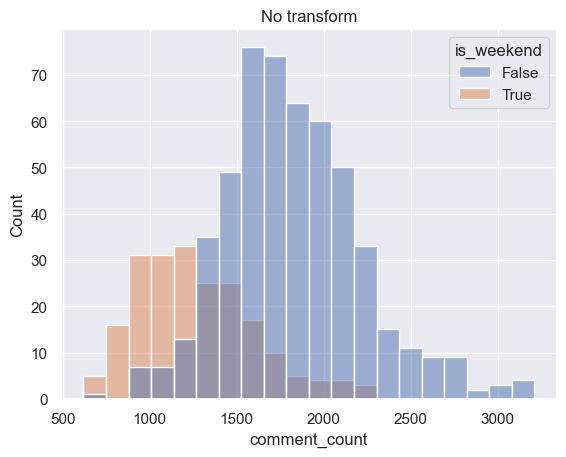

In [9]:
fig = reddit_weekends.draw_histogram(df, title="No transform")

p_value:	0.0
WD normality:	0.0004
WE normality:	0.31494
Variance test:	0.00042
p_value:	0.0
WD normality:	0.0
WE normality:	0.0
Variance test:	0.0
p_value:	0.0
WD normality:	0.03687
WE normality:	0.10761
Variance test:	0.55605
p_value:	0.0
WD normality:	0.0
WE normality:	0.0
Variance test:	0.0


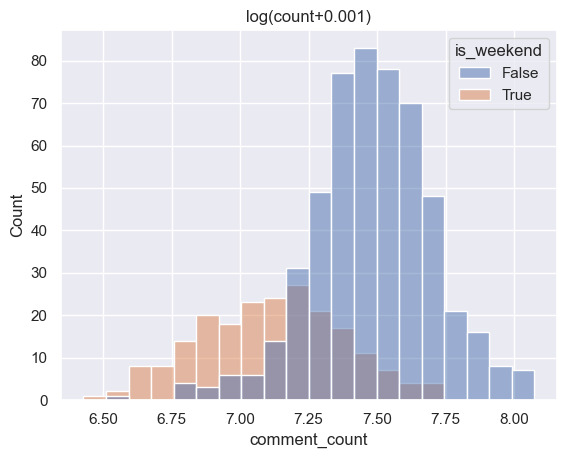

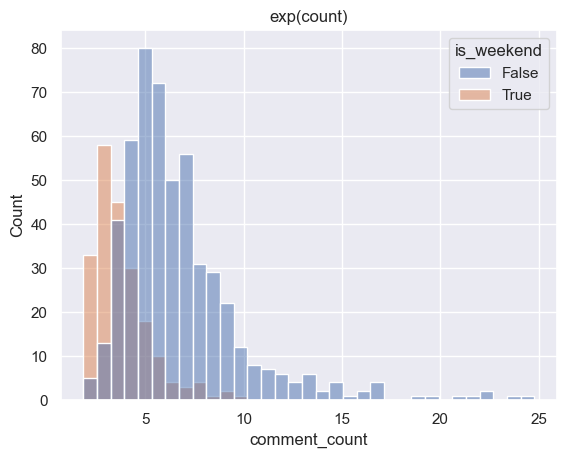

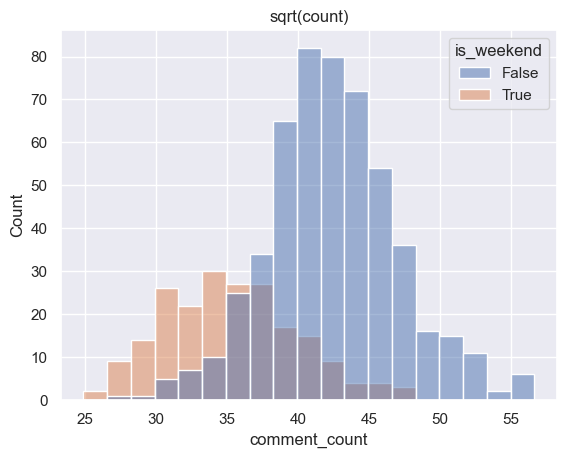

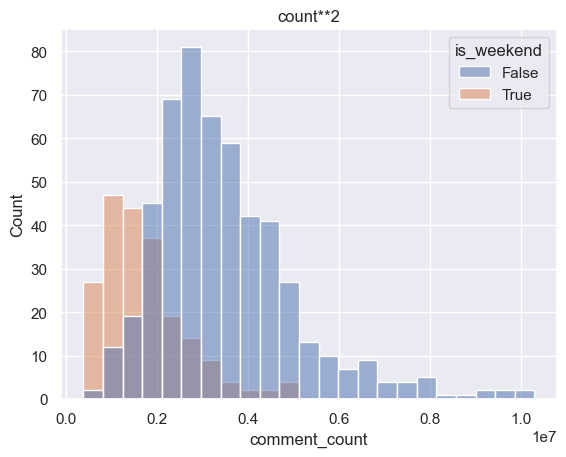

In [10]:
transformations = {
    "log(count+0.001)": lambda x: np.log(x+0.001), # +0.001 pour éviter un log(0)
    "exp(count)": lambda x: np.exp(x * 0.001),
    "sqrt(count)": np.sqrt,
    "count**2": lambda x: x**2,
}

for key, func in transformations.items():
    tmp_df = df.copy()
    
    tmp_df["comment_count"] = tmp_df["comment_count"].apply(func)
    reddit_weekends.draw_histogram(tmp_df, title=key)
    
    _wd, _we = reddit_weekends.split_data(tmp_df)
    _ = reddit_weekends.tests(_wd, _we, verbose=True)

# Correction 2: le théorème central limite pourrait nous sauver.

Le théorème central limite dit que si nos nombres sont suffisamment grands et que nous examinons les moyennes de l'échantillon, alors le résultat devrait être normal.
Essayons cela: nous combinerons tous les jours de semaine et de week-end de chaque paire année/semaine et prendrons la moyenne de leurs décomptes (non transformés).

Astuces: vous pouvez obtenir une "année" et un "numéro de semaine" à partir des deux premières valeurs renvoyées par date.isocalendar(). Cette année et ce numéro de semaine vous donneront un identifiant pour la semaine. Utilisez Pandas pour regrouper par cette valeur et agréger en prenant la moyenne. 

Remarque: l'année renvoyée par isocalendar n'est pas toujours la même que l'année de la date (autour de la nouvelle année). Utilisez l'année de l'isocalendar qui est correcte dans ce cas.

Vérifiez ces valeurs pour la normalité et la variance égale. Appliquez un test T si cela a du sens. (Indice : youpi !)

Nous devrions noter que nous modifions subtilement la question ici. La nouvelle questions ressemble plutôt à "le nombre de commentaires le week-end diffère-t-il du nombre de commentaires les jours de semaine pour chaque semaine?"

In [11]:
clt = reddit_weekends.central_limit_theorem(df)
clt.head()

     iso_year  iso_week  is_weekend  comment_count
0        2011        52        True          995.0
1        2012         1       False         1561.6
2        2012         1        True         1163.0
3        2012         2       False         2062.8
4        2012         2        True         1372.0
..        ...       ...         ...            ...
205      2013        51       False         1964.0
206      2013        51        True         1173.5
207      2013        52       False         1354.4
208      2013        52        True         1117.5
209      2014         1       False         1437.0

[210 rows x 4 columns]


,iso_year,iso_week,is_weekend,comment_count
0,2011,52,True,995.0
1,2012,1,False,1561.6
2,2012,1,True,1163.0
3,2012,2,False,2062.8
4,2012,2,True,1372.0


p_value:	0.0
WD normality:	0.30826
WE normality:	0.15295
Variance test:	0.20384


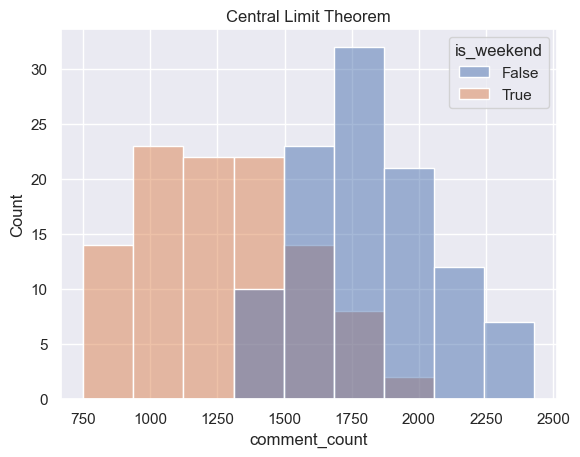

In [12]:
reddit_weekends.draw_histogram(clt, "Central Limit Theorem")

_wd, _we = reddit_weekends.split_data(clt)
_ = reddit_weekends.tests(_wd, _we, verbose=True)

## Correction 3: un test non paramétrique pourrait nous sauver.

L'autre option que nous avons dans notre boîte à outils : un test statistique qui ne se soucie pas autant de la forme de son entrée. Le test U de Mann – Whitney ne suppose pas de valeurs distribuées normalement ni de variance égale.

Effectuez un test U sur les décomptes (initiaux non transformés, non agrégés). Notez que nous devrions faire ici un test bilatéral, qui correspondra aux autres analyses. Assurez-vous que les arguments de la fonction sont corrects.

Encore une fois, notez que nous modifions subtilement la question à nouveau. Si nous parvenons à une conclusion à cause d'un test U, c'est quelque chose comme "il n'est pas également probable qu'il y a un plus grand nombre de commentaires le week-end par rapport aux jours de semaine".

In [13]:
p_utest = reddit_weekends.mann_whitney_u_test(wd, we)
print(f"Mann-Whitney U-test p-value: {p_utest}")

Mann-Whitney U-test p-value: 8.624453234734304e-53


# Réponses courtes

1. Laquelle des quatre transformations suggérées vous rapproche le plus de satisfaire les hypothèses d'un test T?
    - La transformation `sqrt(count)` se rapproche le plus de satisfaire les hypothèses d'un test T. Avec une `p_value` de `55.605%` pour le test de variance `levene`, il est probable que les échantillons proviennent de populations ayant des variances égales, ce qui est l'hypothèse clé pour le test T.

2. J'ai donné des explications imprécises en mots de ce que le test hebdomadaire et le test de Mann-Whitney testaient réellement. Faites de même pour le test T d'origine et pour le test T des données transformées. Autrement dit, décrivez quelle serait la conclusion si vous pouviez rejeter l'hypothèse nulle dans ces tests.
    - **Test T d'origine**: Ce test T compare les moyennes des commentaires en semaine et en week-end sans transformation. Si l'hypothèse nulle est rejetée, cela signifie qu'il y a une différence significative entre le nombre moyen de commentaires publiés en semaine et le week-end, sur la base des données brutes.
    - **Test T des données transformées**: Le test T est effectué après transformation (par exemple, avec `sqrt(count)` ou `log(count+0.001)`). On applique ces transformations afin, idéalement, de corriger les données et de satisfaire les hypothèses sous-jacentes du test pour que les résultats soient fiables. Si l'hypothèse nulle est rejetée, cela signifie que même après transformation des données, les moyennes des deux groupes restent significativement différentes.

3. Parmi les quatre approches, laquelle, selon vous, réussit le mieux à obtenir une réponse à la question initiale : "y a-t-il un nombre différent de commentaires Reddit publiés en semaine et le week-end?" Expliquez brièvement pourquoi. (Il n'est pas clair qu'il y ait une seule réponse correcte à cette question, mais il y en a de mauvaises!)
    - L'approche utilisant le test de Mann-Whitney semble la plus appropriée. C'est un test non paramétrique qui ne fait pas d'hypothèses sur la distribution des données. Comme les données brutes ne suivent pas une distribution normale, ce test fournit une réponse potentiellement plus robuste à la question de savoir si les nombres de commentaires diffèrent entre la semaine et le week-end.
    - ~~Cependant, un autre point est à considérer... Le TCL stipule que, lorsqu'on a assez de données, la distribution de la moyenne des échantillons suivra une distribution normale, peu importe la distribution des données initiales. Cela signifie que regrouper les données par année et semaine permet d'obtenir une distribution normale pour la moyenne des échantillons, surtout avec un grand nombre d'observations. Ainsi, les tests qui assument une distribution normale sont maintenant valides.~~

4. En moyenne, sur Reddit /r/canada, en moyenne: est-ce qu'il y a plus de commentaires publiés en semaine ou le week-end ?
    - Selon les graphiques plus haut, on remarque que la moyenne du nombre de commentaires pendant la semaine est plus grande que lors de la fin de semaine. De plus, tous les tests pointent vers la conclusion que les moyennes des deux distributions ne sont pas les mêmes.